## Q1.1 Data transformation

In [22]:
import pandas as pd
import numpy as np
import glob
import os
import csv
import matplotlib.pyplot as plt
from scipy.stats import norm

#### Getting all unique parameters

In [69]:
csv_directory = "data/set-a/"
unique_parameters = set()

# Looping through each patient file and gathering the parameter name
for filename in os.listdir(csv_directory):
    if filename.endswith(".txt"):
        file_path = os.path.join(csv_directory, filename)
        
        with open(file_path, mode='r') as file:
            reader = csv.reader(file)
            for row in reader:
                # Get row parameter name and add to set
                parameter = row[1]
                unique_parameters.add(parameter)

unique_parameters = list(unique_parameters)
unique_parameters.sort()
unique_parameters.remove("ICUType")

print("Unique Parameters:", unique_parameters)
print(len(unique_parameters))

Unique Parameters: ['ALP', 'ALT', 'AST', 'Age', 'Albumin', 'BUN', 'Bilirubin', 'Cholesterol', 'Creatinine', 'DiasABP', 'FiO2', 'GCS', 'Gender', 'Glucose', 'HCO3', 'HCT', 'HR', 'Height', 'K', 'Lactate', 'MAP', 'MechVent', 'Mg', 'NIDiasABP', 'NIMAP', 'NISysABP', 'Na', 'PaCO2', 'PaO2', 'Parameter', 'Platelets', 'RecordID', 'RespRate', 'SaO2', 'SysABP', 'Temp', 'TroponinI', 'TroponinT', 'Urine', 'WBC', 'Weight', 'pH']
42


#### Creating a large table for all patients

In [5]:
# Run this code for each of the sets once to create corresponding .parquet file (change folder names in lines 2 and 40 to "set-x")
file_paths = glob.glob("data/set-c/*.txt")

processed_dfs = []

# Loops through each of the patient .txt file and creates corresponding table. In the end, appends all tables to one big table and saves it as .parquet file
for file in file_paths:
    df = pd.read_csv(file)
    
    # For rounding to the next hour
    df[['Hour', 'Minute']] = df['Time'].str.split(':', expand=True).astype(int)
    df['RoundedHour'] = np.where((df['Hour'] == 0) & (df['Minute'] == 0), 0, ((df['Hour'] * 60 + df['Minute']) // 60 + 1) * 60)
    df['Time'] = df['RoundedHour'].apply(lambda x: f"{x//60:02}:00")

    # If we have two measurements during one hour (e.g, at 00:37 and at 00:57), we take the mean and get one value for the timestamp 01:00
    df_pivot = df.pivot_table(index='Time', columns='Parameter', values='Value', aggfunc='mean').reset_index()

    # Ensure all hours from 00:00 to 48:00 are present
    full_hours = pd.DataFrame({"Time": [f"{h:02}:00" for h in range(49)]})
    df_final = full_hours.merge(df_pivot, on="Time", how="left")

    # Add missing parameters from unique_parameters with NaN values (since not all parameters are measured on one patient)
    for param in unique_parameters:
        if param not in df_final.columns:
            df_final[param] = np.nan

    # Enforce static values to be persistent over all timestamps
    df_final["Age"] = df_final["Age"][0]
    df_final["Height"] = df_final["Height"][0]
    df_final["Weight"] = df_final["Weight"][0]
    df_final["Gender"] = df_final["Gender"][0]
    df_final["RecordID"] = df_final["RecordID"][0]

    processed_dfs.append(df_final)

final_df = pd.concat(processed_dfs, ignore_index=True)

# Saving result and displaying a preview
final_df.to_parquet('processed-data/processed-set-c.parquet', index=False)
final_df.head()

,Time,ALP,ALT,AST,Age,Albumin,BUN,Bilirubin,Creatinine,DiasABP,...,pH,Cholesterol,NIDiasABP,NIMAP,NISysABP,Parameter,RespRate,SaO2,TroponinI,TroponinT
0,00:00,NaN,NaN,NaN,71.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01:00,NaN,NaN,NaN,71.0,NaN,NaN,NaN,NaN,59.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,02:00,NaN,NaN,NaN,71.0,NaN,36.0,NaN,3.7,49.333333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,03:00,NaN,NaN,NaN,71.0,NaN,NaN,NaN,NaN,59.000000,...,7.34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,04:00,NaN,NaN,NaN,71.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Getting the labels from Outcomes-x.txt files and creating corresponding .parquet files

In [ ]:
# Run this code for each of the sets once to create corresponding .parquet file (change folder names in lines 2 and 4 to "set-x")
df = pd.read_csv('data/Outcomes-c.txt')
df_labels = df[["RecordID","In-hospital_death"]]
df_labels.to_parquet('processed-data/processed-outcomes-c.parquet', index=False)

## Q2.2 Exploratory Data Analysis

#### Visualizing the data

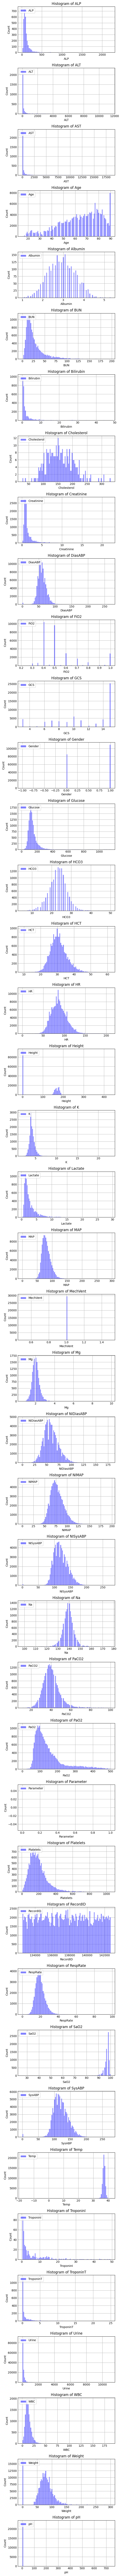

In [73]:
N_points = 196000
n_bins = 100

fig, axs = plt.subplots(nrows=len(unique_parameters), ncols=1, figsize=(6, len(unique_parameters) * 3))

for i, e in enumerate(unique_parameters):
    current_row = np.array(df[e], dtype=float)
    # Remove NaNs
    current_row = current_row[~np.isnan(current_row)]  

    axs[i].hist(current_row, bins=n_bins, density=False, alpha=0.5, color='b', edgecolor='white')
    axs[i].set_title(f"Histogram of {e}")
    axs[i].set_xlabel(e)
    axs[i].set_ylabel("Count")
    axs[i].legend([e], loc='upper left')

plt.tight_layout()
plt.show()

#### Observation
We can observe the typical normally distributed bell shape quite often. However, there are variables, we we can see a different pattern. For example, for both the variables "Height" and "Weight" it can be observed that their value is sometimes equal to "-1.0". We think that this is a different way of saying that there was no measurement taken for these variables at that point in time, meaning it should essentially be a NaN value. Additionally, the variable "Gender" is simply encoded as "1.0" or "0.0" standing for either male or female.

C:\Users\ycoll\AppData\Local\Temp\ipykernel_23204\96325806.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(10, 6))


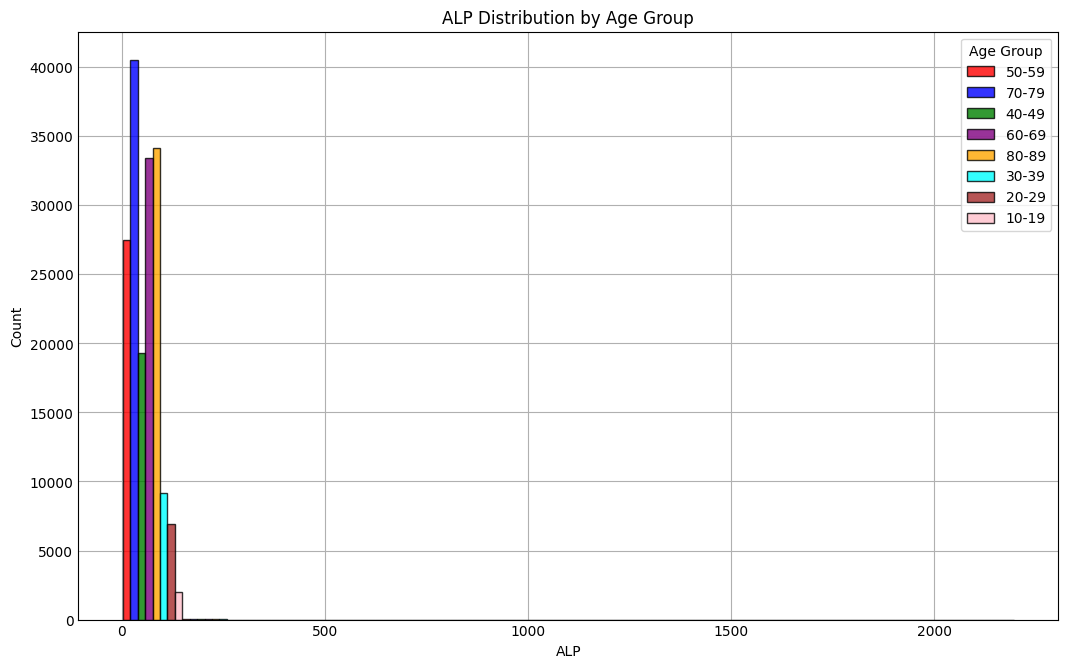

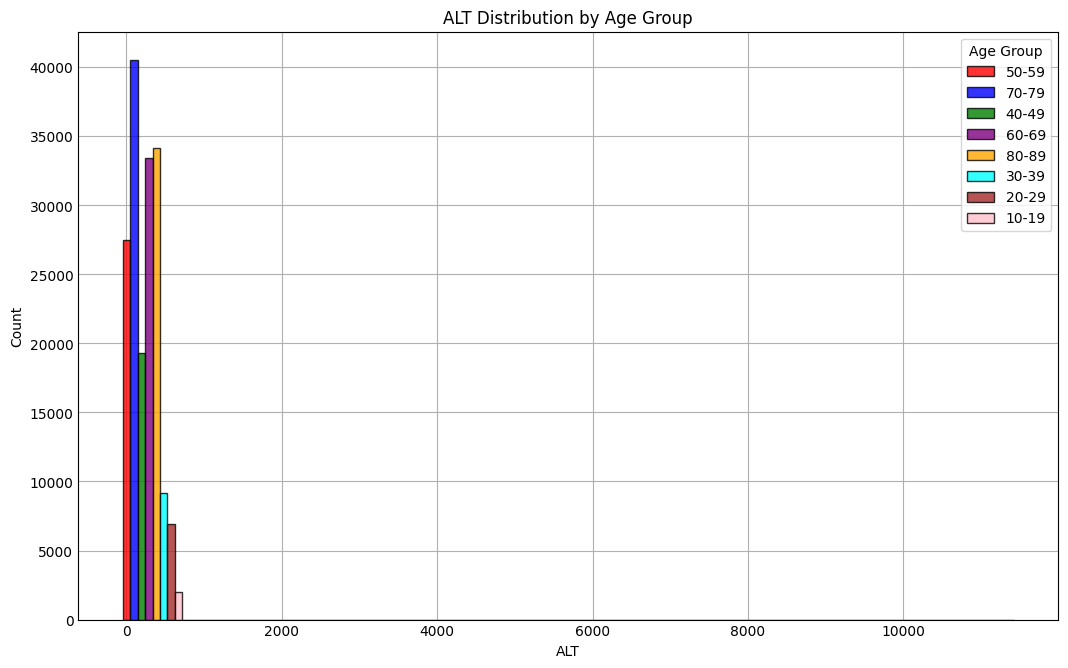

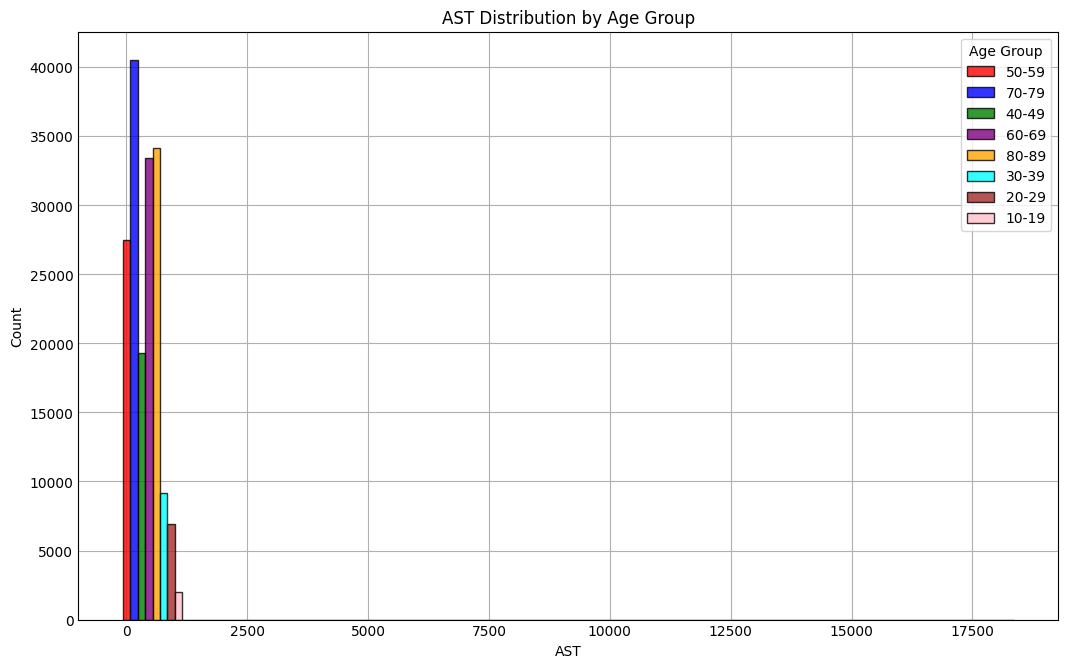

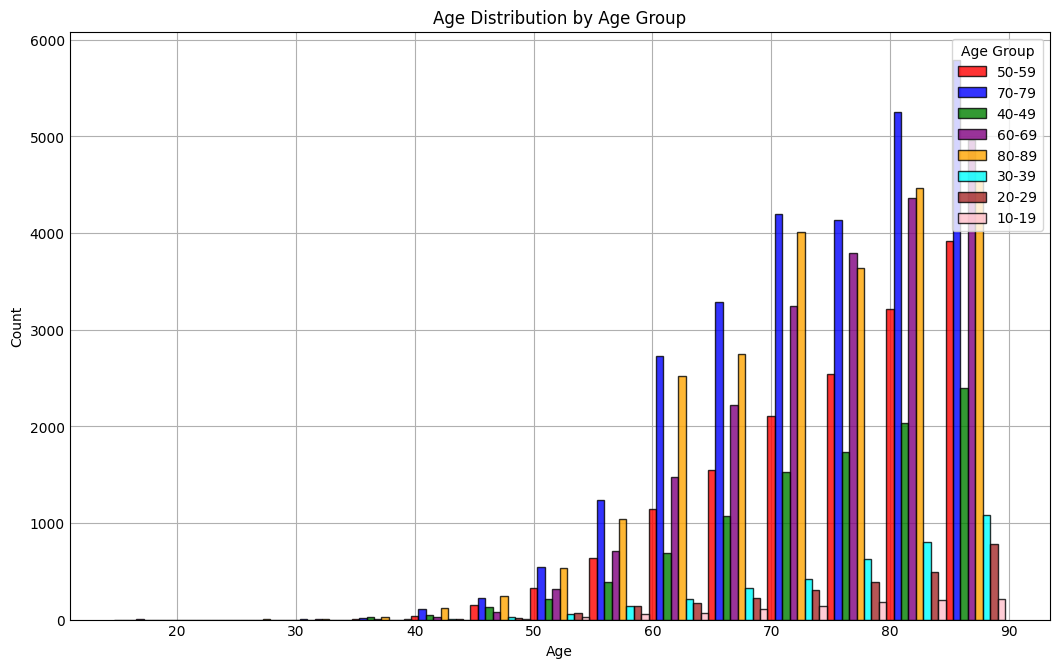

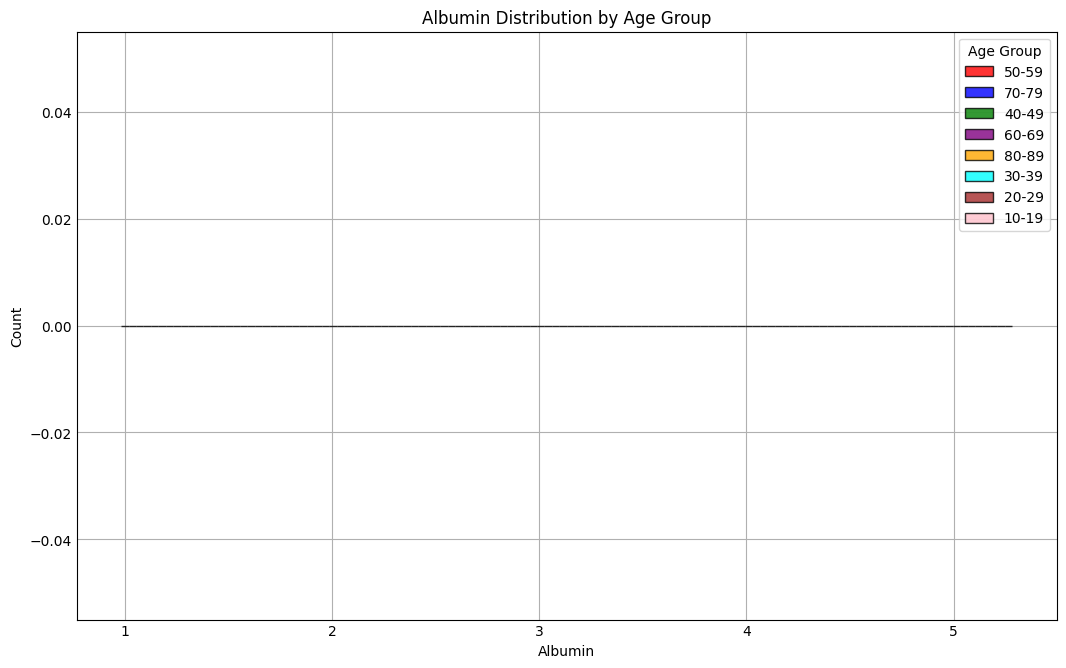

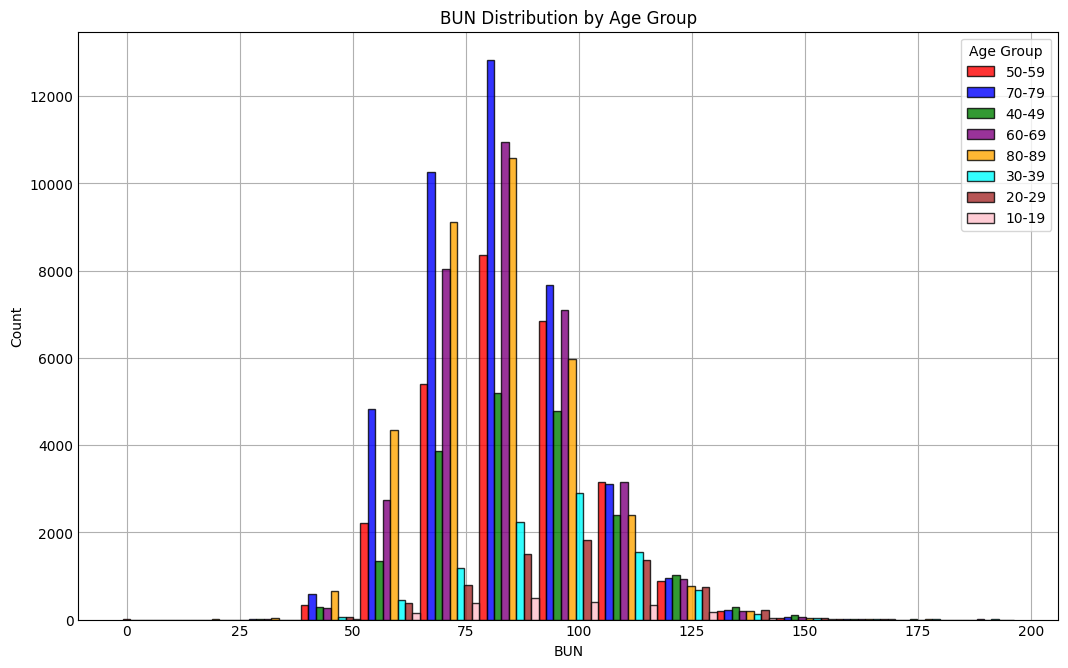

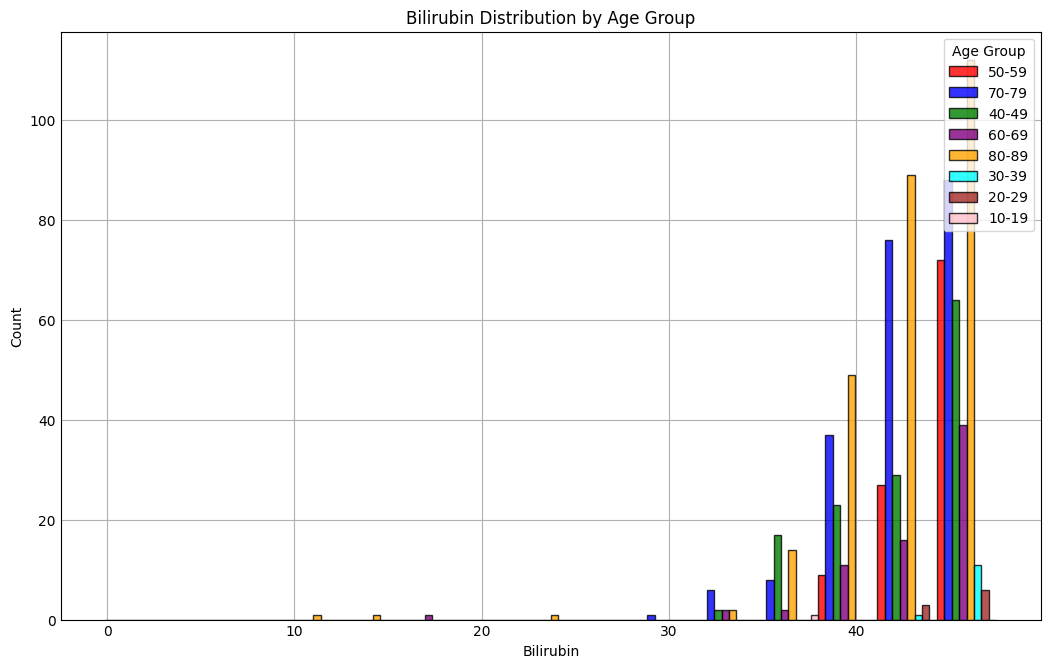

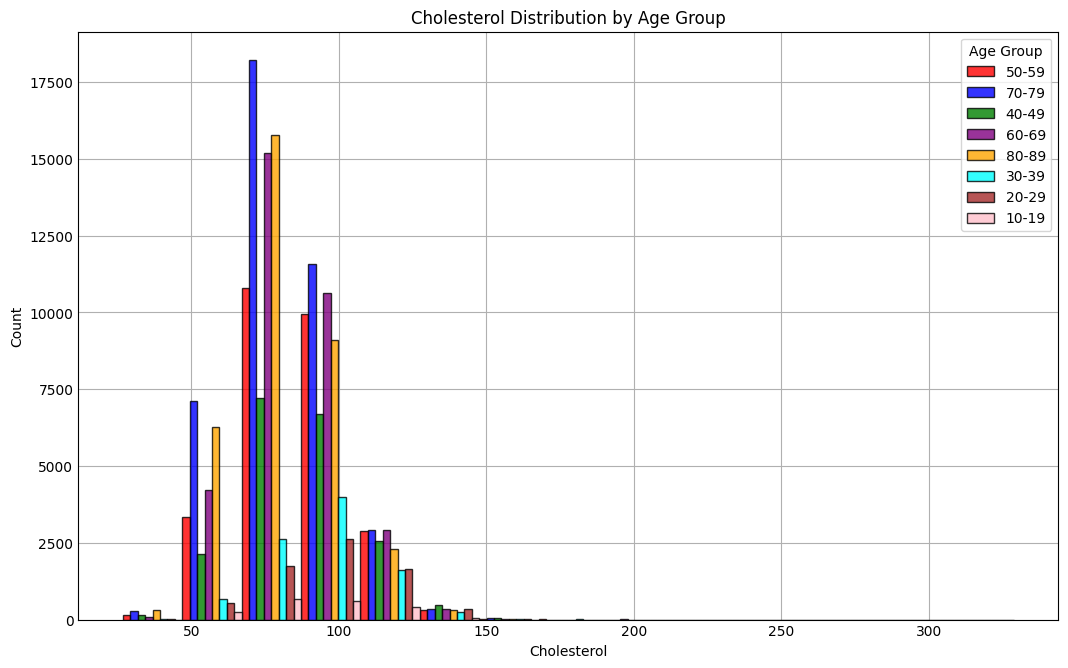

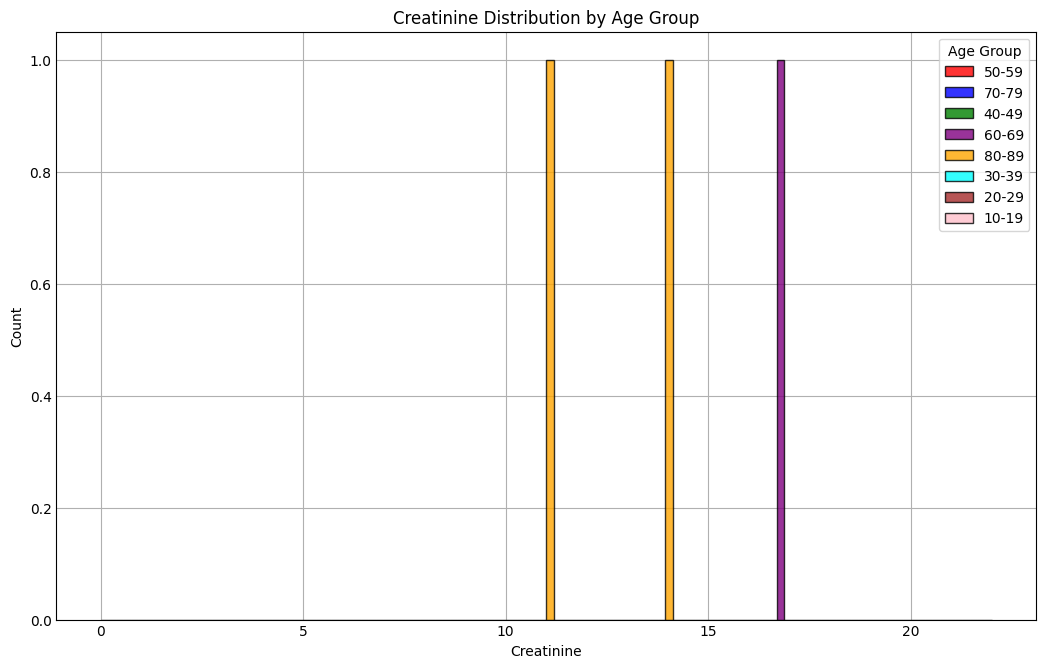

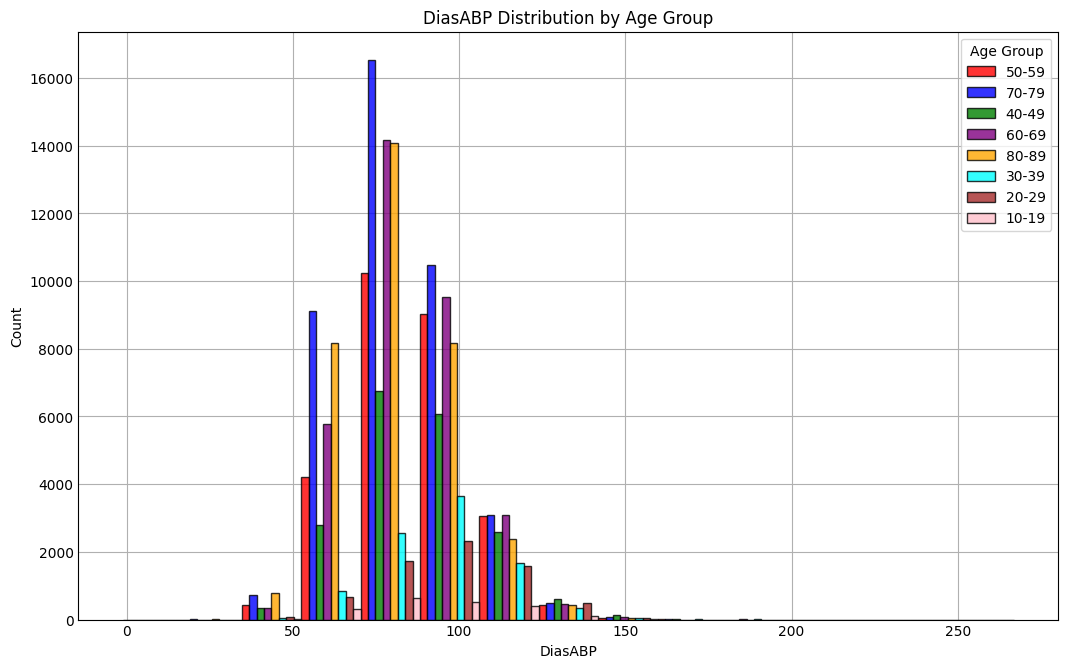

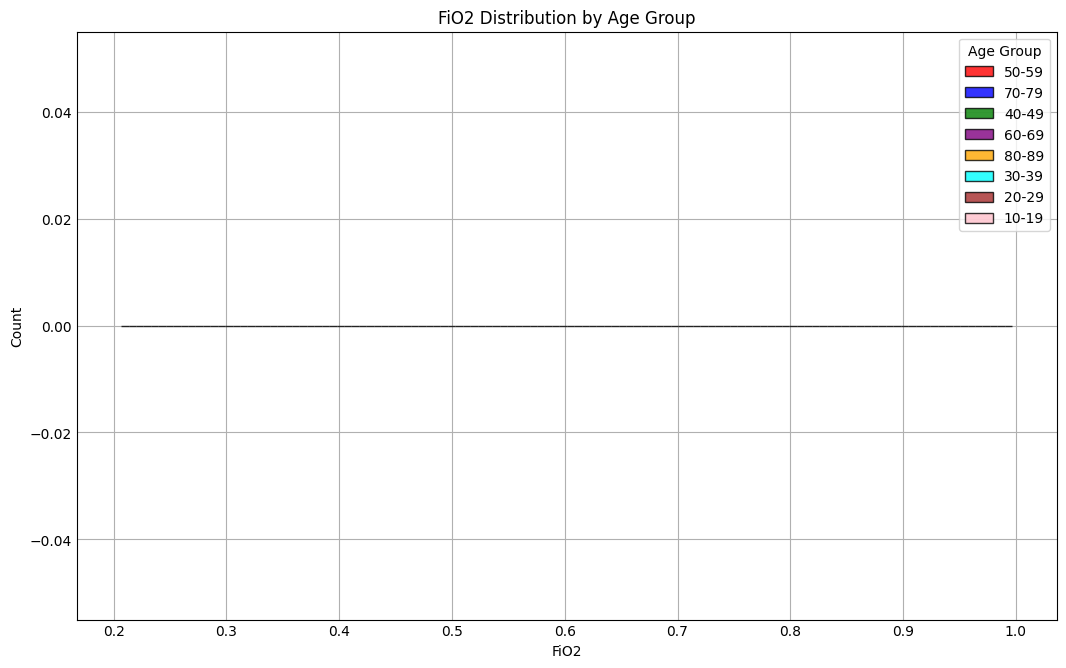

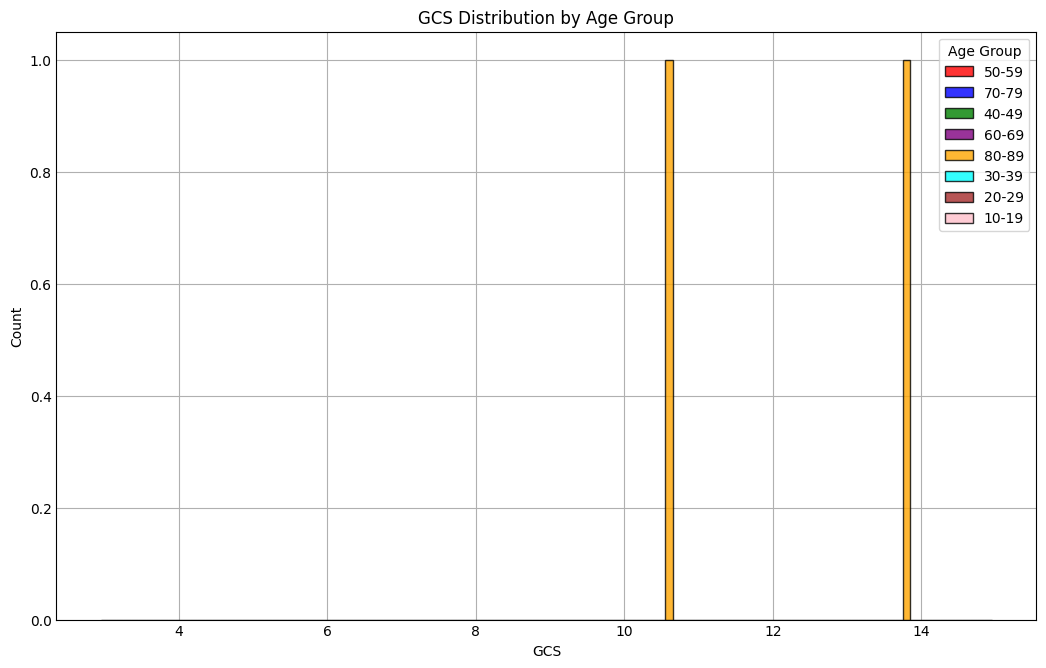

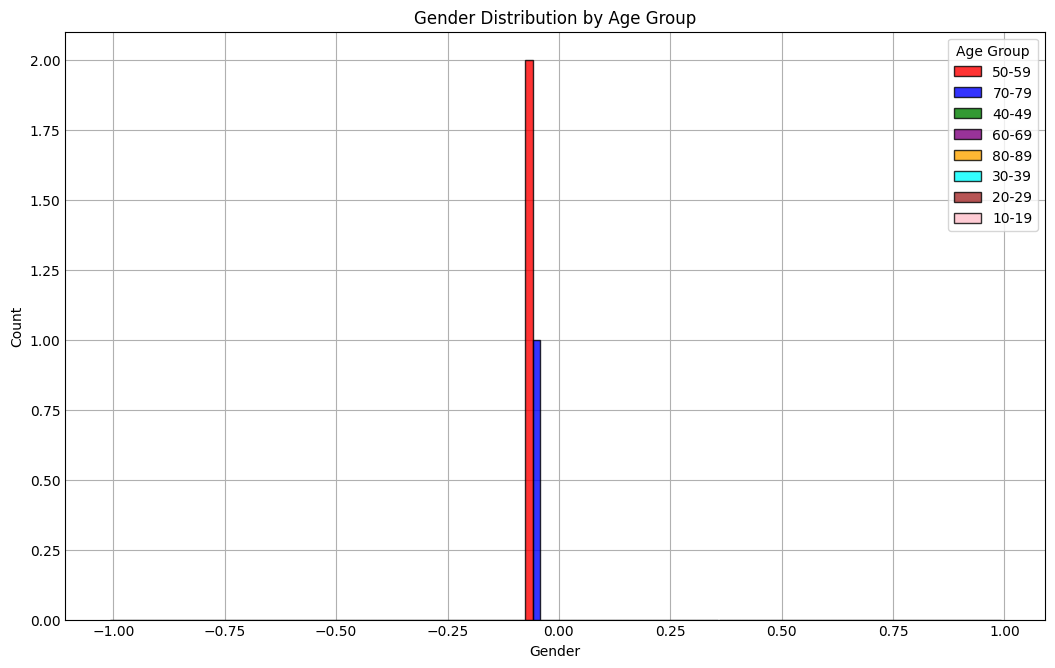

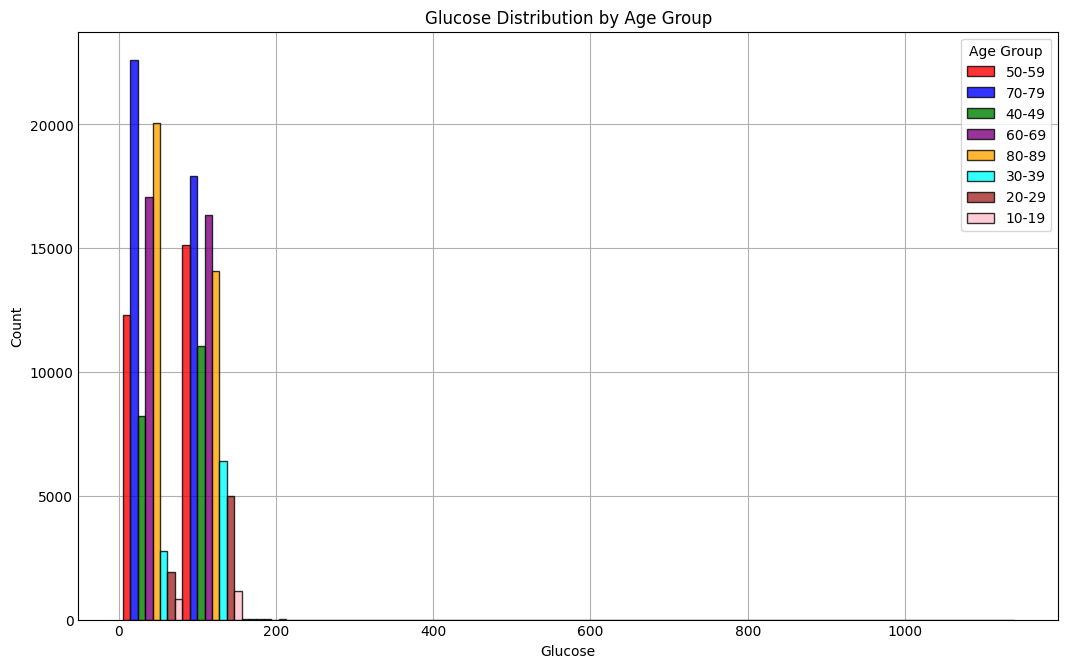

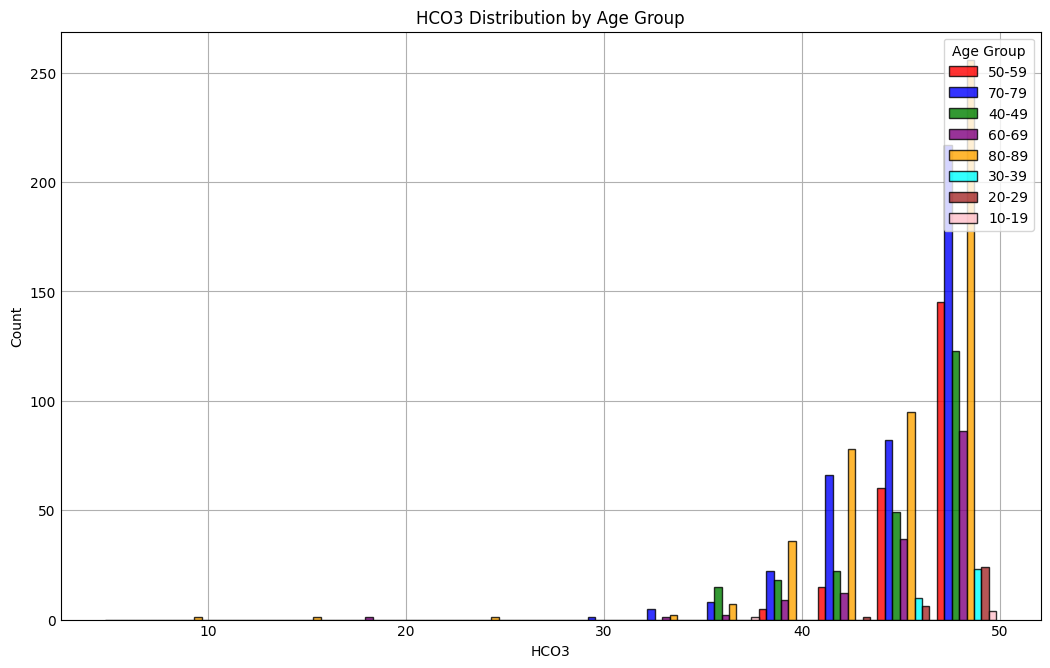

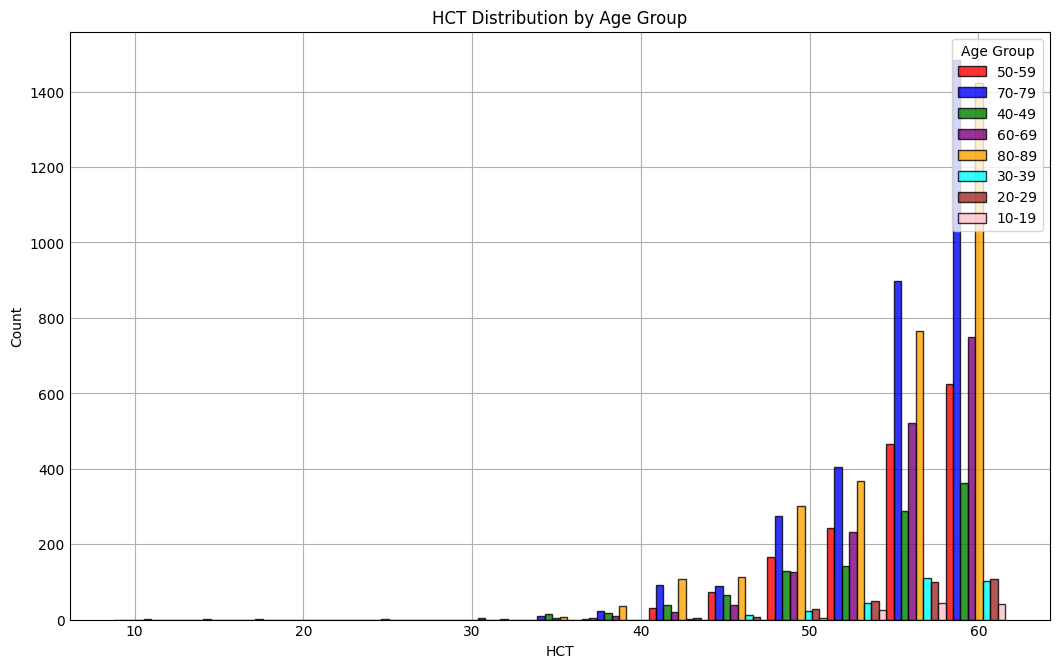

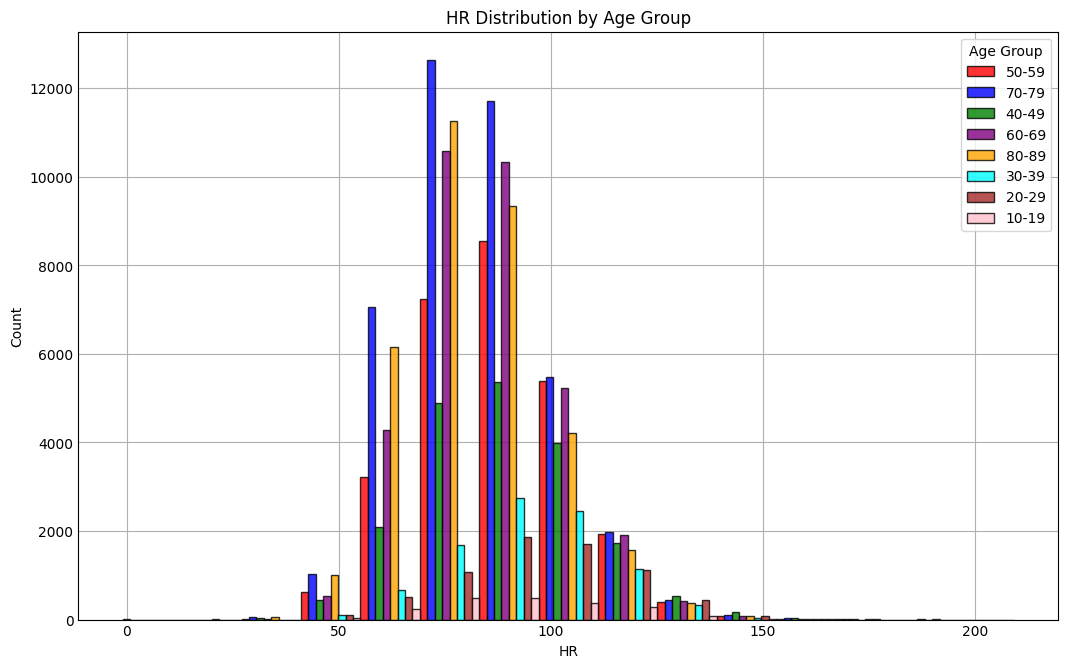

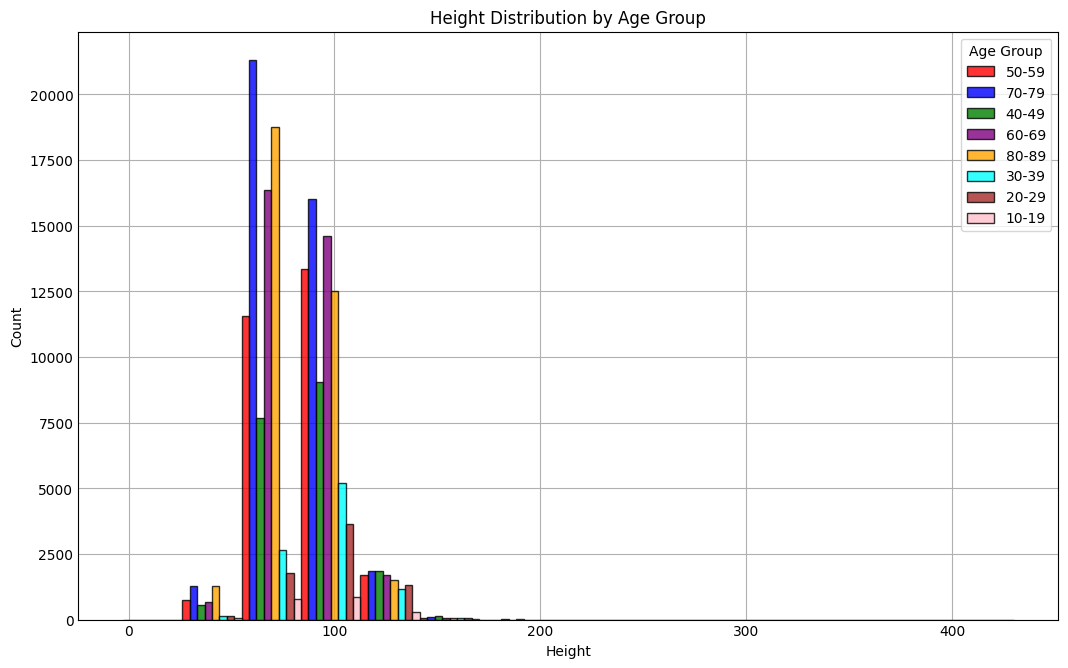

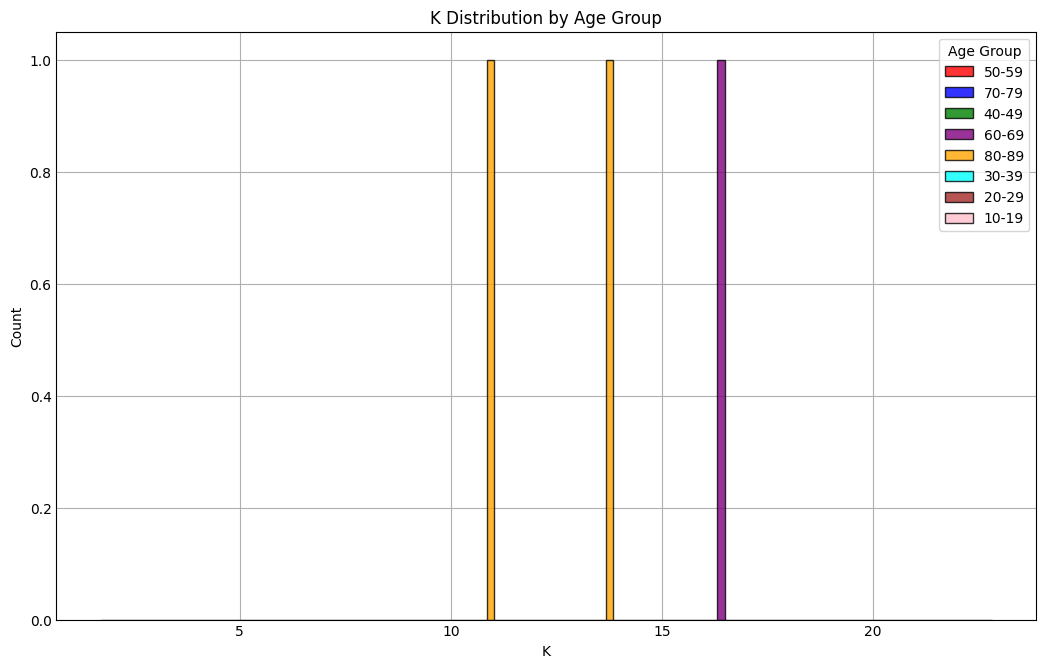

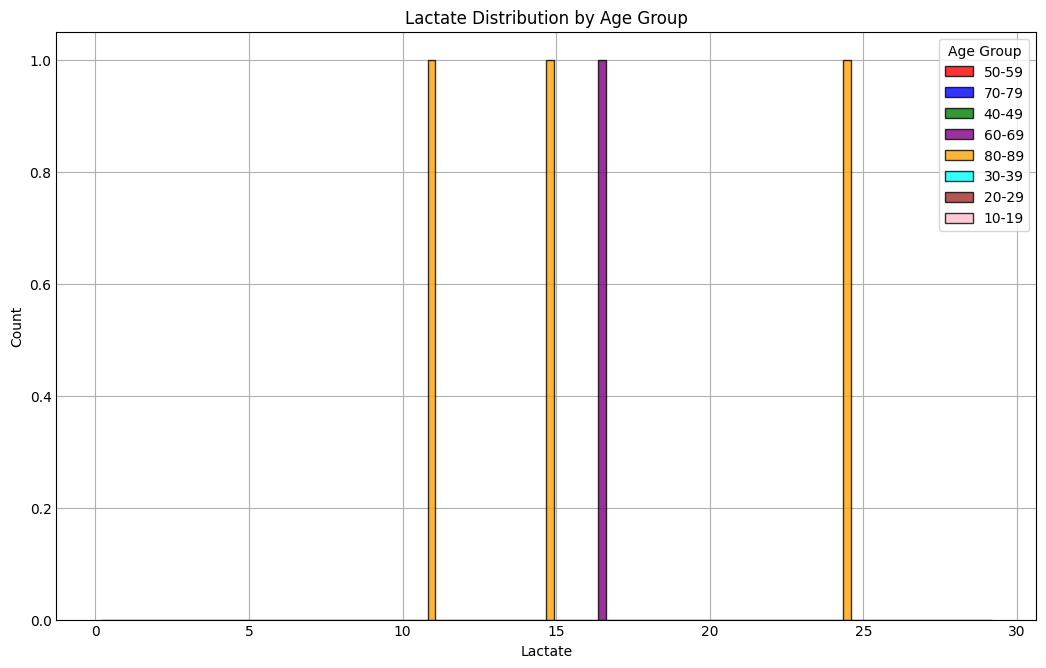

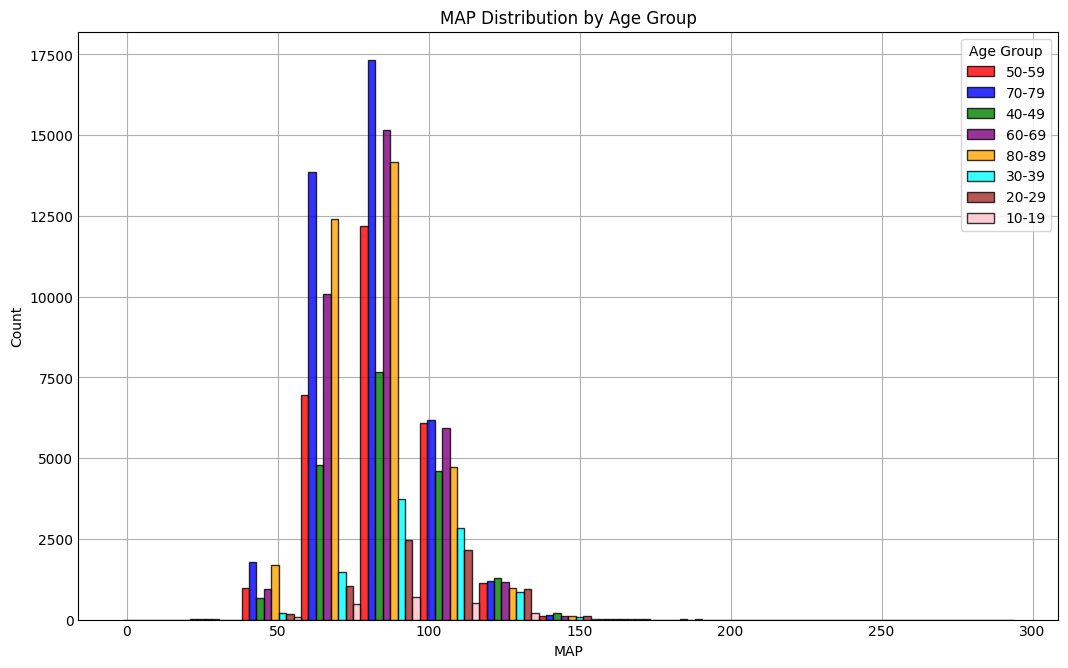

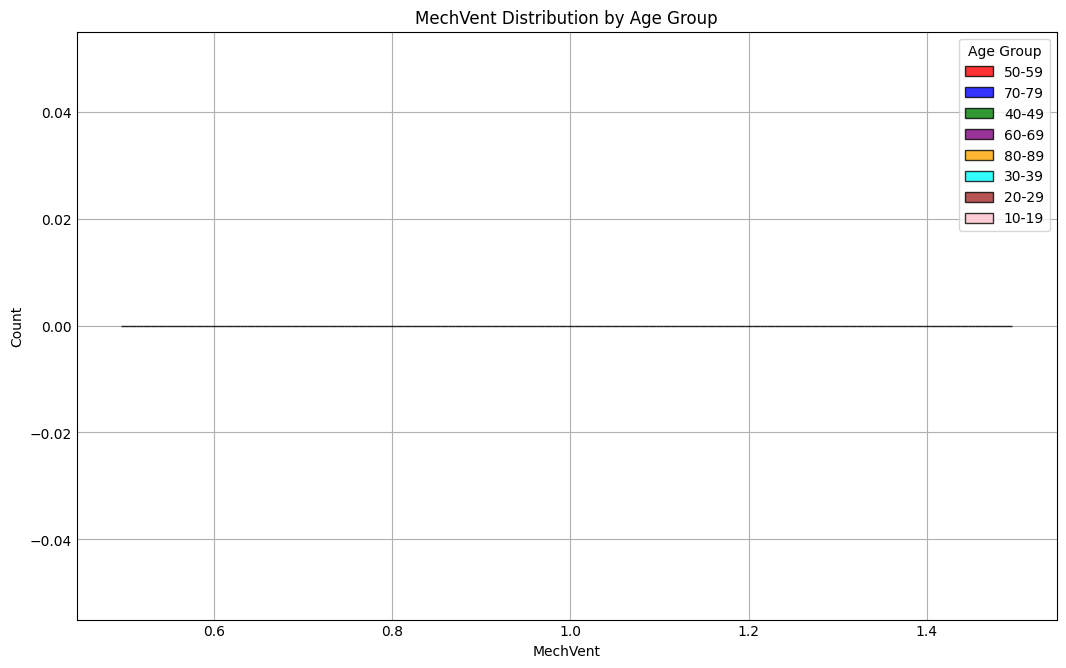

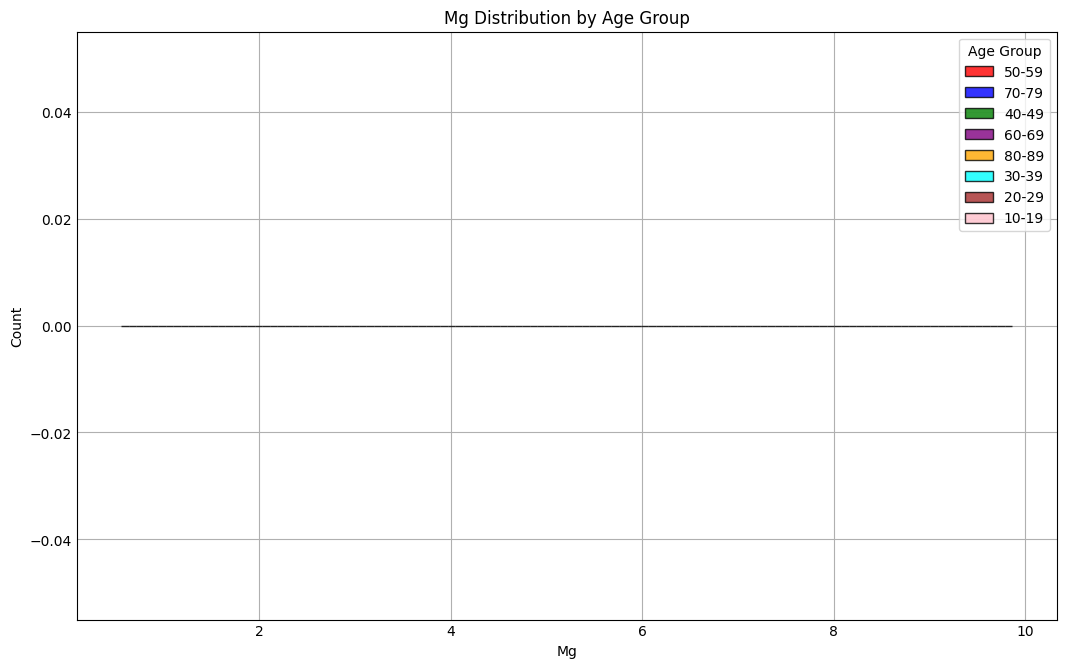

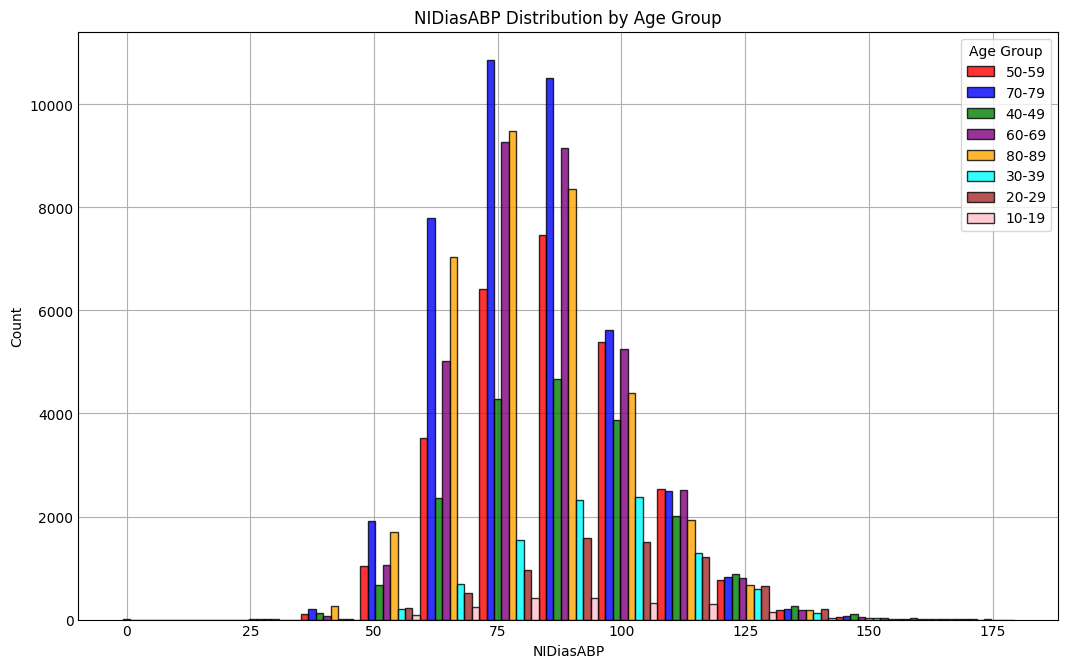

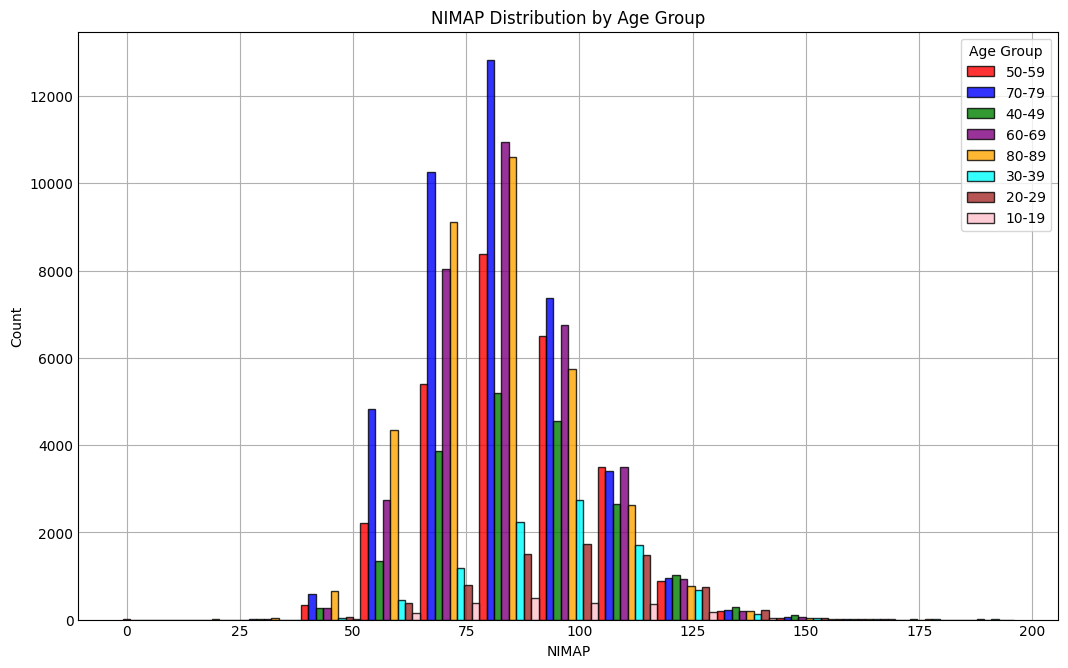

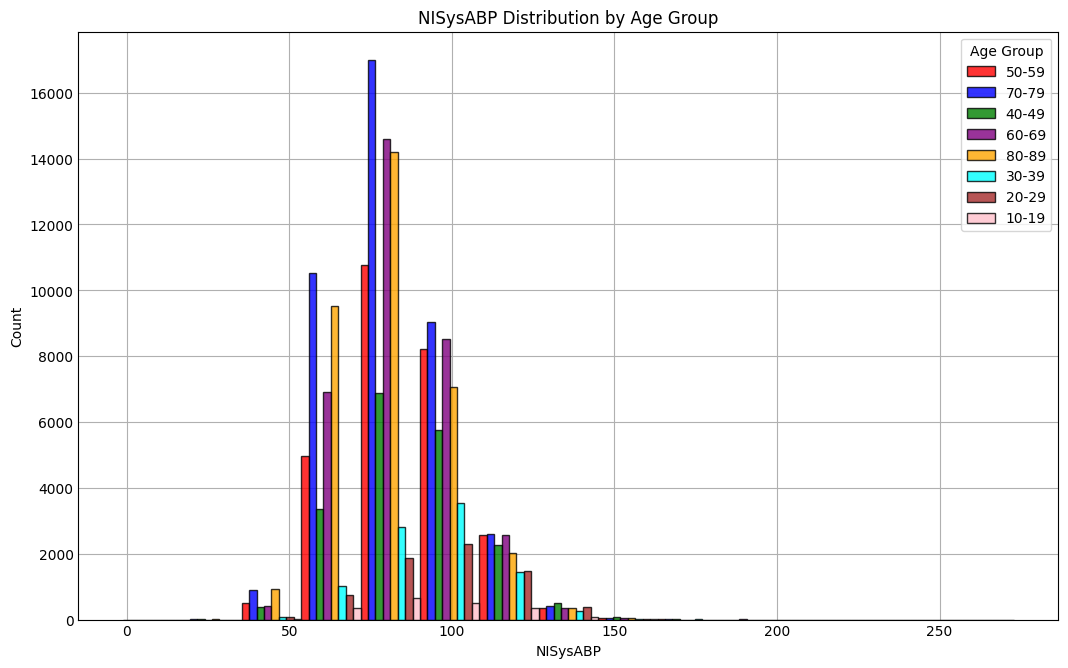

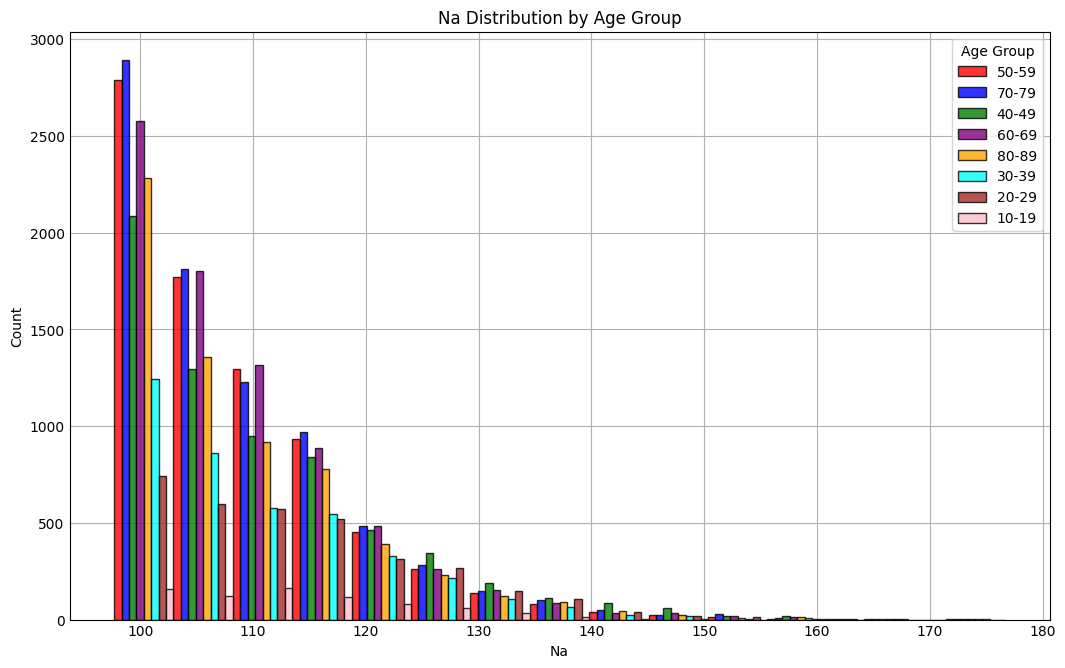

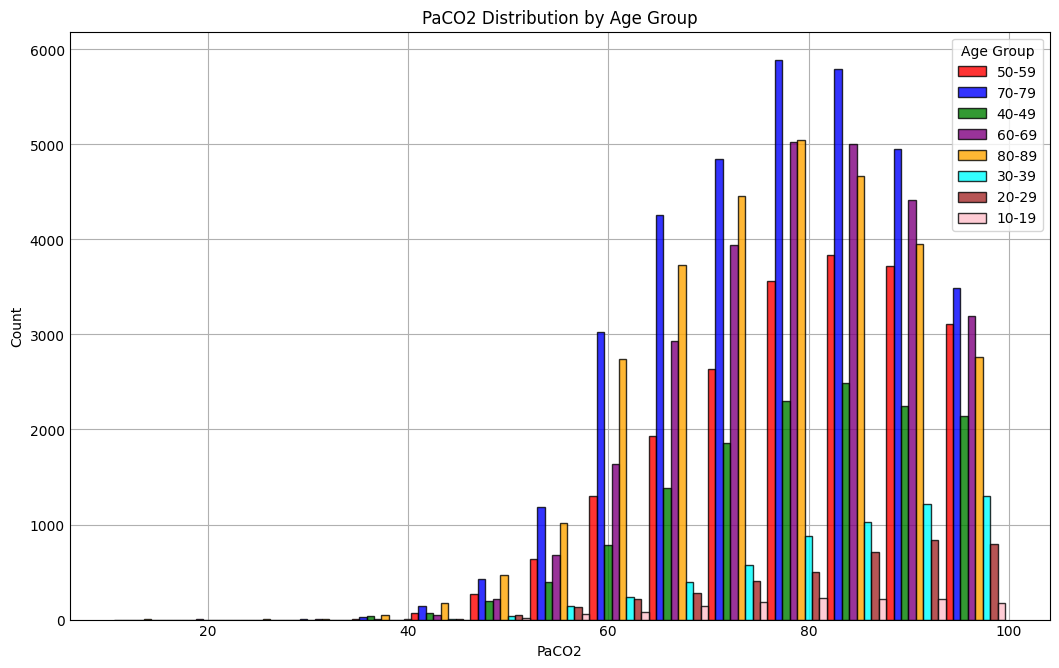

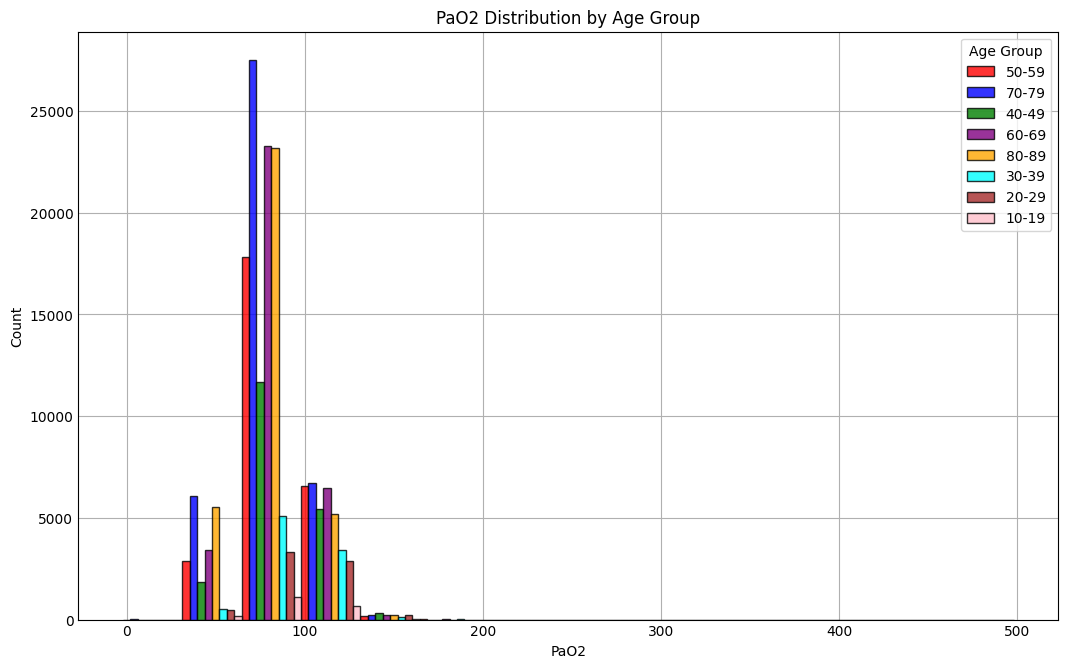

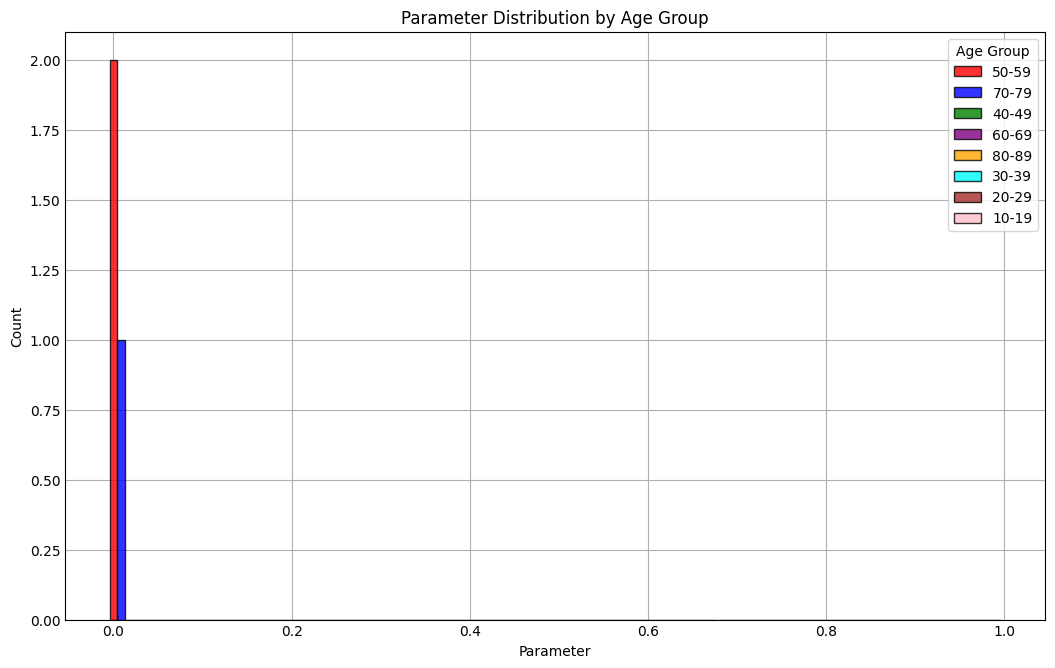

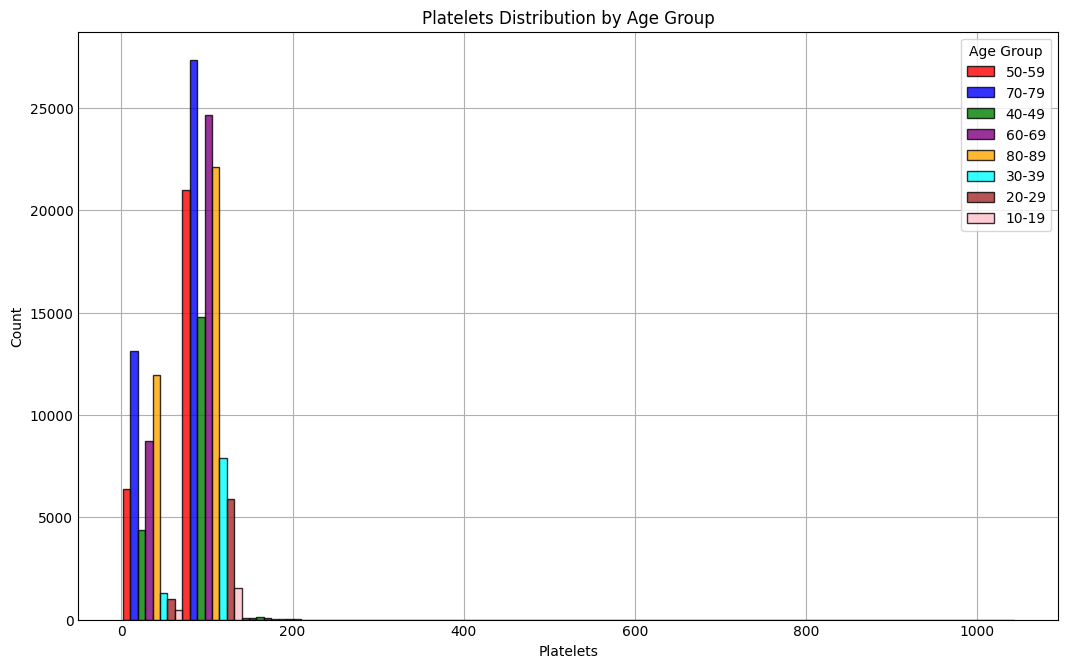

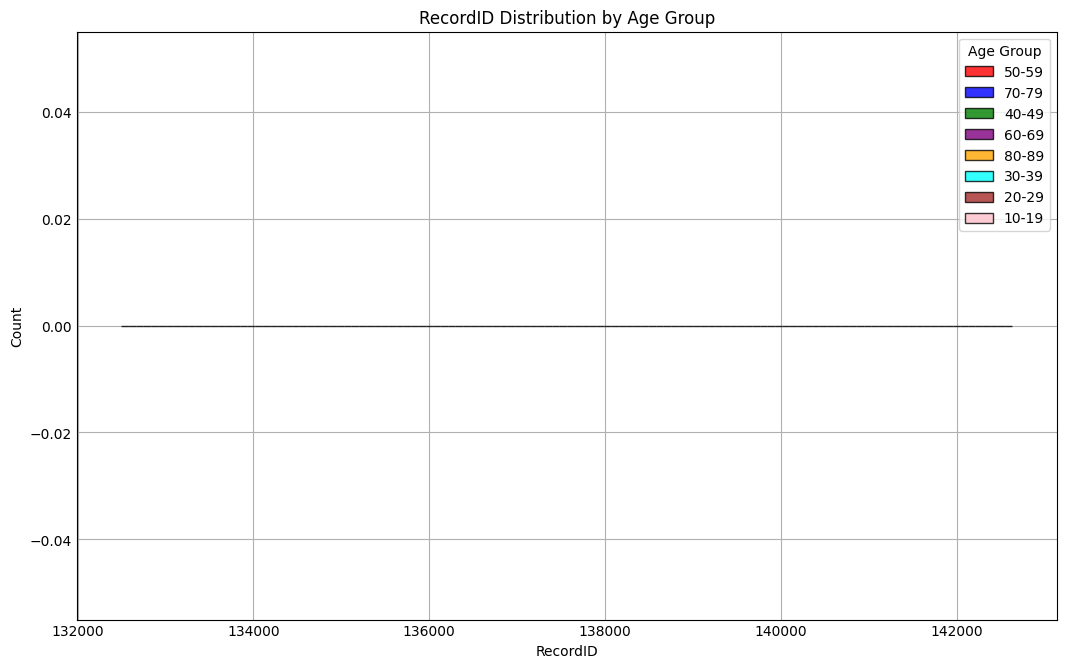

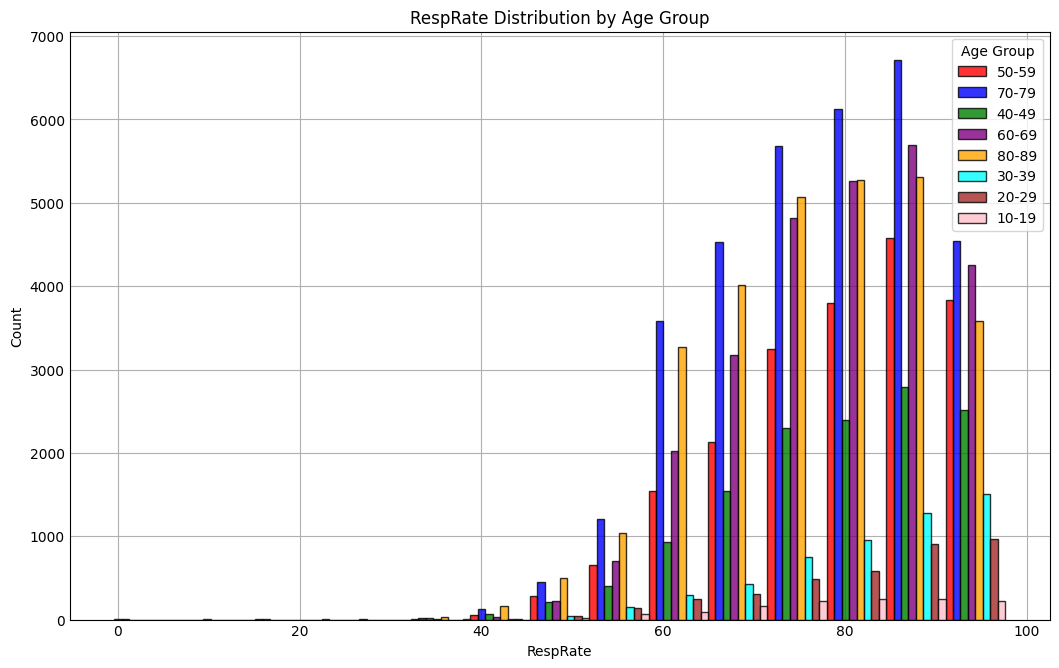

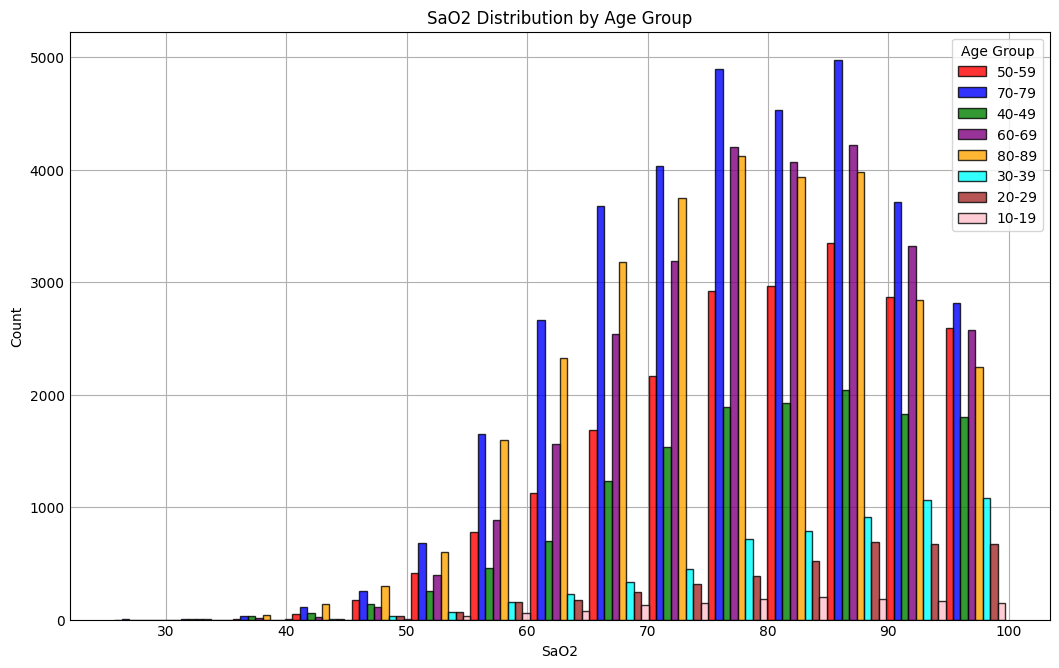

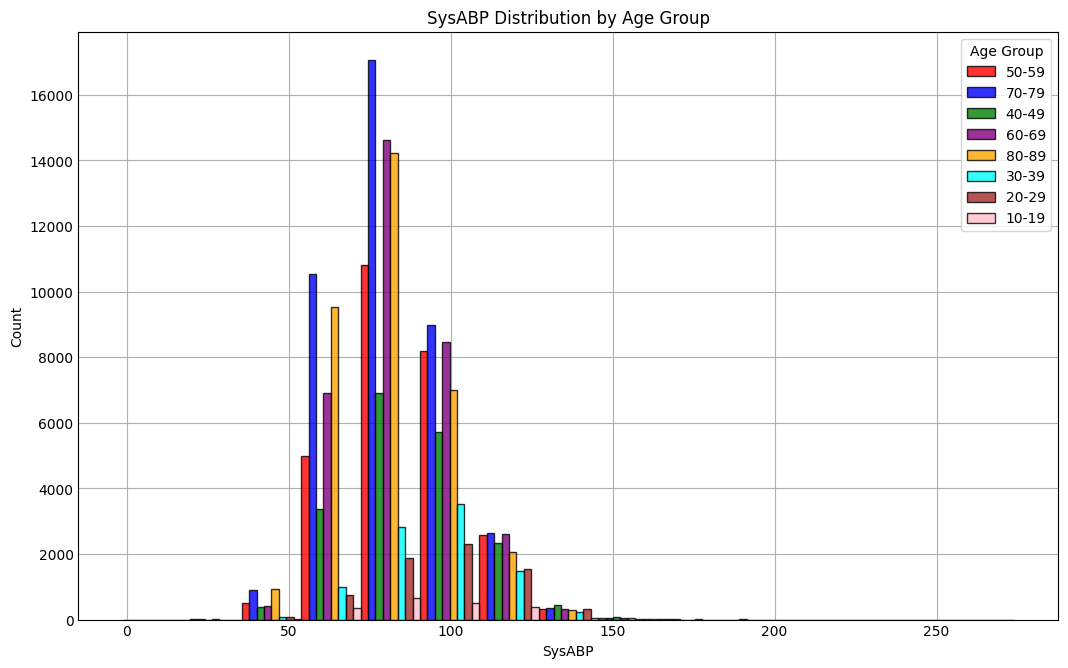

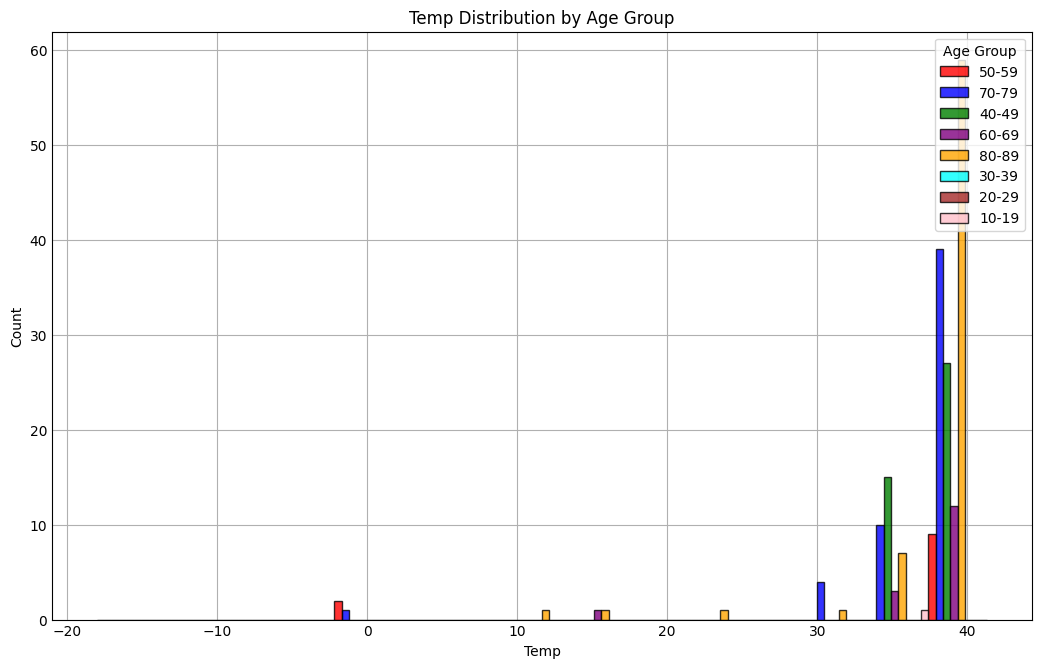

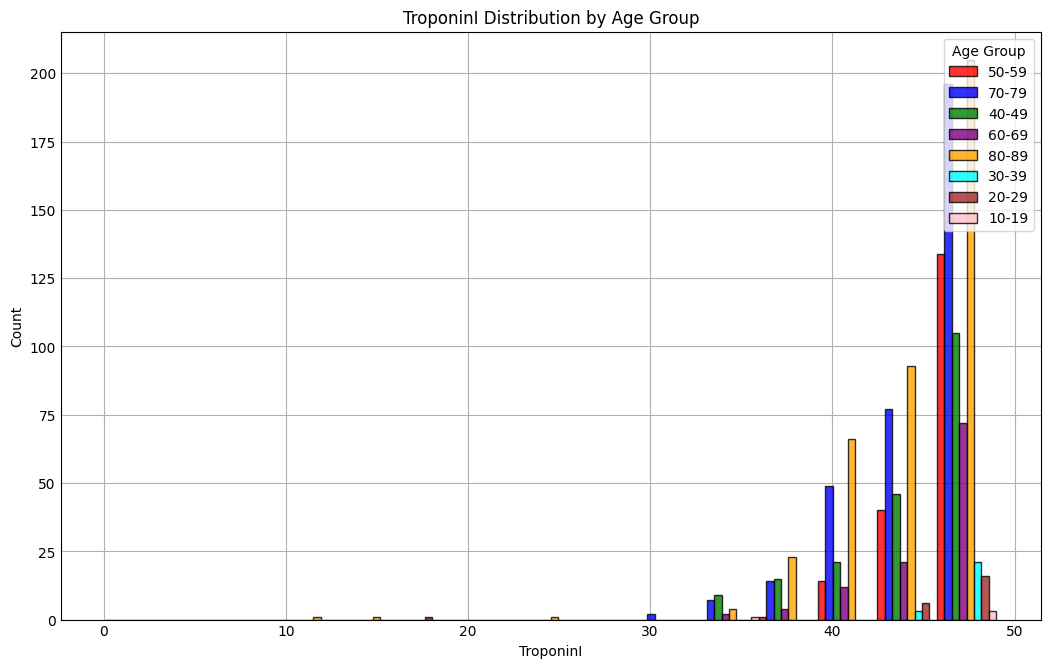

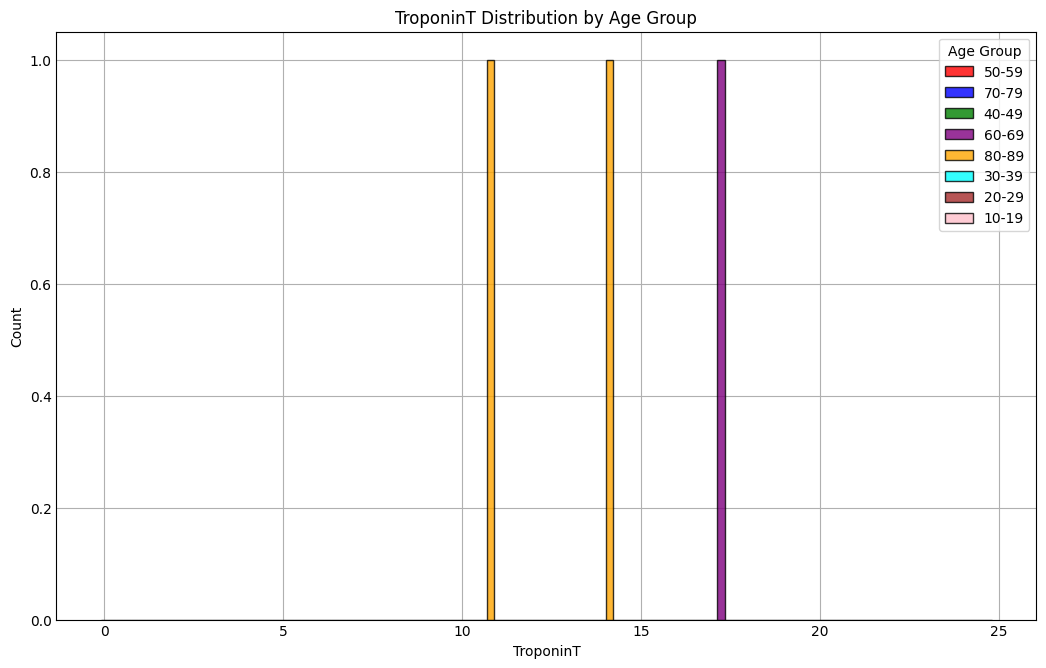

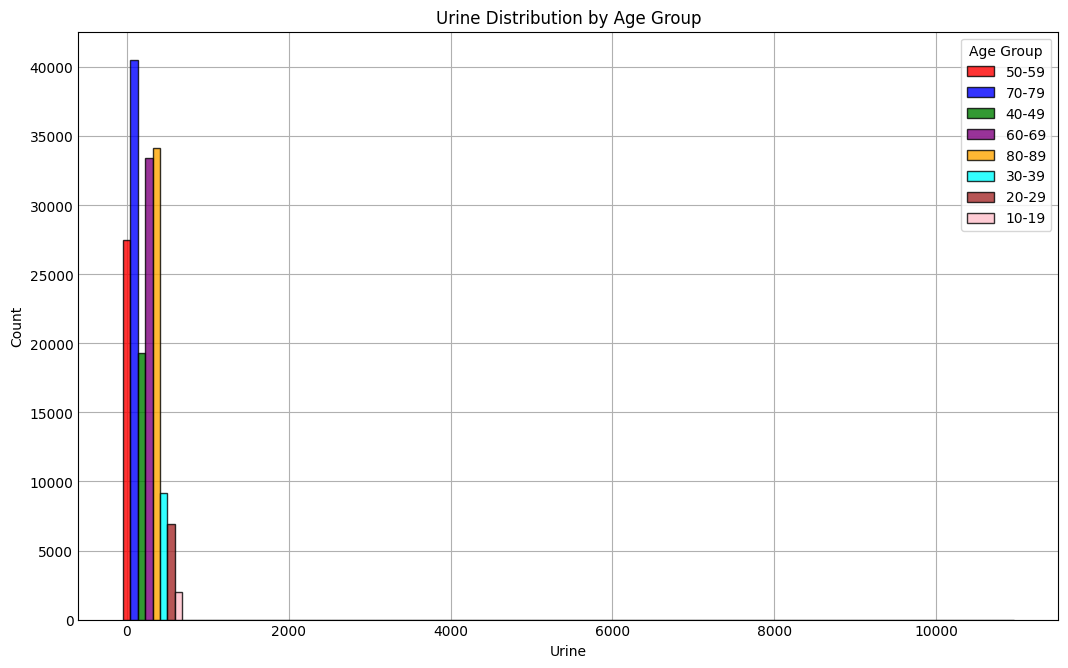

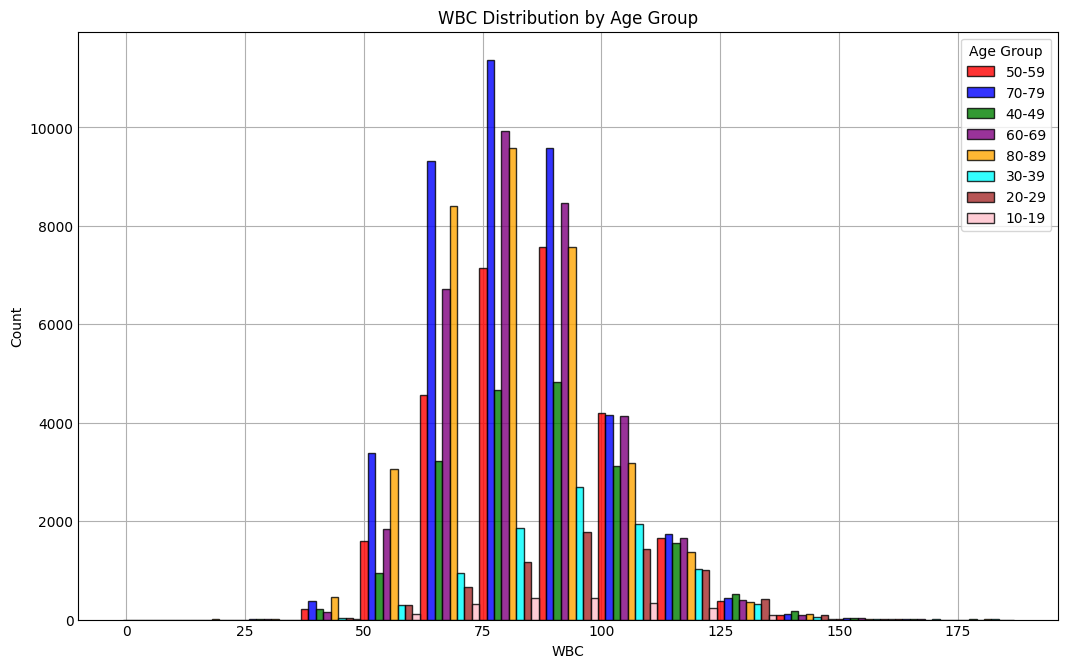

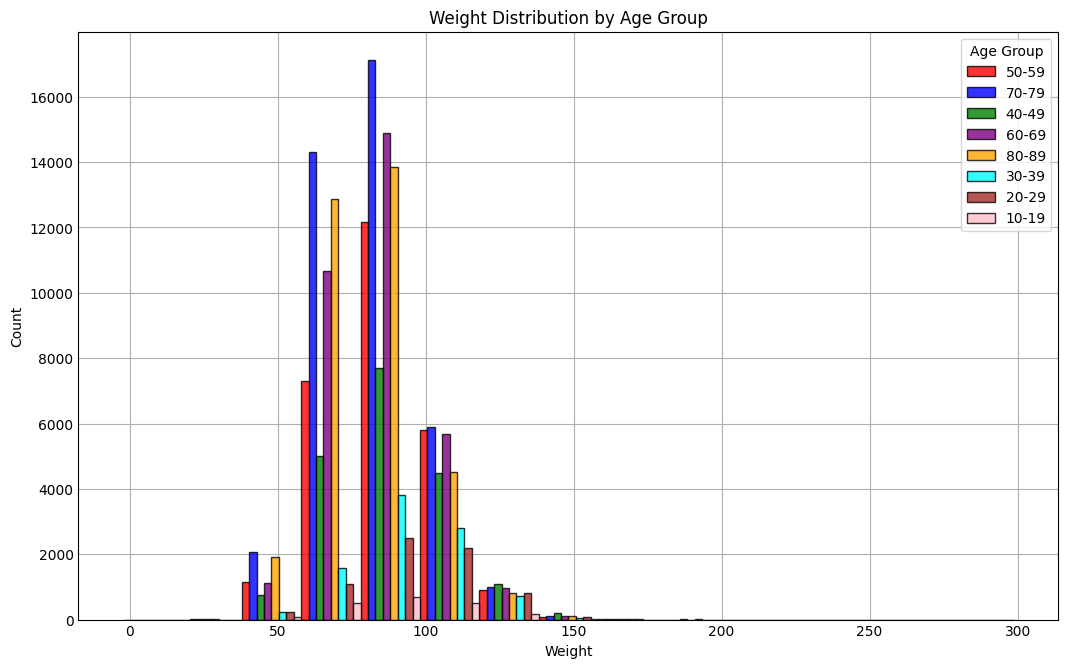

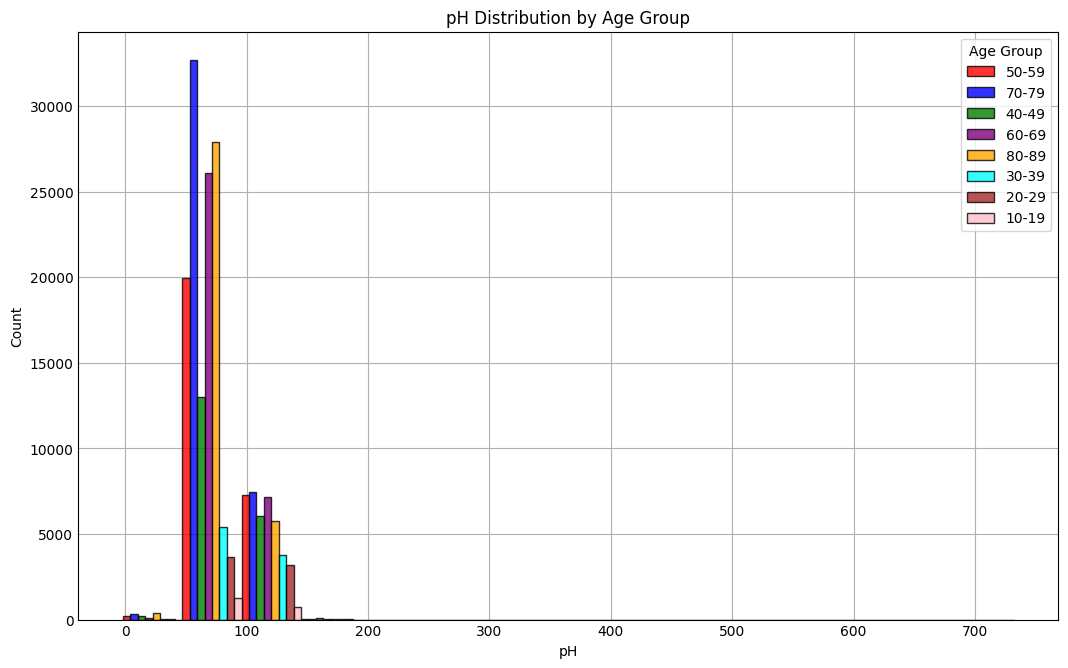

In [82]:
# Define age bins
bins = list(range(0, 100, 10))  # Bins of 10 years
labels = [f"{b}-{b+9}" for b in bins[:-1]]

for e in unique_parameters:
    df["AgeGroup"] = pd.cut(df["Age"], bins=bins, labels=labels)
    fig, ax = plt.subplots(figsize=(10, 6))
    d_new = df[e].dropna()

    bin_edges = np.histogram_bin_edges(d_new, bins=15)  # Get bin edges
    width = (bin_edges[1] - bin_edges[0]) / len(df["AgeGroup"].unique())  # Adjust width
    color_list = ['red', 'blue', 'green', 'purple', 'orange', 'cyan', 'brown', 'pink', 'gray', 'lime']

    for i, age_group in enumerate(df["AgeGroup"].unique()):
        subset = df[df["AgeGroup"] == age_group]
        counts, _ = np.histogram(subset["HR"], bins=bin_edges)
        ax.bar(bin_edges[:-1] + i * width, counts, width=width, alpha=0.8, label=str(age_group), edgecolor="black", color=color_list[i % len(color_list)])

    ax.set_xlabel(e)
    ax.set_ylabel("Count")
    ax.set_title(e + " Distribution by Age Group")
    ax.legend(title="Age Group", loc="upper right")

plt.show()